In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yaml
import joblib
import os
 
import clearml
from clearml import Task,Dataset

In [3]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ESG2JYW25TMQ8SG3QUENQHQNL99XXG
%env CLEARML_API_SECRET_KEY=F1gti6U7SrNVrM-t8tptJIeLpSzmcSHdBbC_4LHKBSTa2Xmfig3gjt2MO_2D6P15UH8

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ESG2JYW25TMQ8SG3QUENQHQNL99XXG
env: CLEARML_API_SECRET_KEY=F1gti6U7SrNVrM-t8tptJIeLpSzmcSHdBbC_4LHKBSTa2Xmfig3gjt2MO_2D6P15UH8


## Препроцесс и описательная статитстика

all_posts_v1.csv - спаршенные данные по 4 группам тематики метро

In [5]:

df_raw = pd.read_csv('../data/raw/all_posts_v1.csv')

## Data Version 1

In [ ]:
# # Версионирование сырых данных в Clear ML
# from clearml import Dataset

# # Создаем датасет ClearML
# dataset = Dataset.create(
#     dataset_name="VK_Posts_Raw",
#     dataset_project="NLP Course Project"
# )

# # Добавляем файл с данными в датасет
# dataset.add_files('../data/raw/all_posts_v1.csv')

# # Загружаем метаданные о датасете
# dataset.set_metadata({
#     'description': 'Сырые данные постов VK для NLP проекта',
#     'source': 'VK API',
#     'total_rows': len(df_raw),
#     'columns': list(df_raw.columns),
#     'data_types': str(df_raw.dtypes.to_dict()),
#     'groups_count': df_raw['group_name'].nunique(),
#     'date_range': f"{df_raw['date'].min()} - {df_raw['date'].max()}"
# })

# # Финализируем версию датасета
# dataset.finalize(auto_upload=True)

# print("✅ Сырые данные заверсионированы в Clear ML")
# print(f"📊 ID датасета: {dataset.id}")

ClearML results page: https://app.clear.ml/projects/622af47656c34ad9b3d661810c7915f5/experiments/ccfc863a8a10474e97c6fb3615748fec/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/622af47656c34ad9b3d661810c7915f5/experiments/ccfc863a8a10474e97c6fb3615748fec
Displaying metadata in the UI is only supported for pandas Dataframes for now. Skipping!
Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (1 files compressed to 15.8 MiB) to https://files.clear.ml


████████████████████████████████ 100% | 15.80/15.8 MB [00:34<00:00,  2.17s/MB]: 


File compression and upload completed: total size 15.8 MiB, 1 chunk(s) stored (average size 15.8 MiB)
✅ Сырые данные заверсионированы в Clear ML
📊 ID датасета: ccfc863a8a10474e97c6fb3615748fec


## Task Clear ml

In [ ]:
# from clearml import Task

# # Инициализация задачи
# task = Task.init(
#     project_name="NLP Course Project",
#     task_name="VK Posts EDA Analysis", 
#     task_type=Task.TaskTypes.data_processing,
#     reuse_last_task_id=False
# )

# # Логируем параметры
# task.set_parameter("dataset_path", "../data/raw/all_posts_v1.csv")
# task.set_parameter("target_group", "mosmetro")


ClearML Task: created new task id=f7da764b1fa543e3bdca91e6315f5866
======> WARNING! Git diff too large to store (10829kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/b93684681a0643b0b06120e4b9c7d805/experiments/f7da764b1fa543e3bdca91e6315f5866/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [10]:
print(f"📊 Размер датасета: {df_raw.shape[0]} строк, {df_raw.shape[1]} колонок")
print("\n📝 Типы данных:")
print(df_raw.dtypes)

📊 Размер датасета: 72152 строк, 11 колонок

📝 Типы данных:
post_id               object
group_name            object
group_display_name    object
text                  object
comments_count         int64
likes                  int64
reposts                int64
views                  int64
date                  object
url                   object
text_length            int64
dtype: object


In [11]:
df_raw['group_name']

0           mosmetro
1           mosmetro
2           mosmetro
3           mosmetro
4           mosmetro
            ...     
72147    gazetametro
72148    gazetametro
72149    gazetametro
72150    gazetametro
72151    gazetametro
Name: group_name, Length: 72152, dtype: object

Анализ всех групп

In [12]:

group_analysis = df_raw.groupby('group_name').agg({
    'comments_count': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'likes': ['mean'],
    'views': ['mean'],
    'text_length': ['mean']
}).round(2)

 
group_analysis.columns = [
    'posts_count', 'comments_total', 'comments_mean', 'comments_std', 
    'comments_min', 'comments_max', 'likes_mean', 'views_mean', 'text_length_mean'
]

print("📈 СТАТИСТИКА ПО ГРУППАМ:")
print(group_analysis.sort_values('posts_count', ascending=False))

📈 СТАТИСТИКА ПО ГРУППАМ:
             posts_count  comments_total  comments_mean  comments_std  \
group_name                                                              
moscowmetro        40958          384319           9.38         15.01   
gazetametro        16026           34938           2.18         13.25   
mosmetro            7937          272011          34.27        141.28   
mirmetro            7231           59280           8.20         24.20   

             comments_min  comments_max  likes_mean  views_mean  \
group_name                                                        
moscowmetro             0          1477        9.13      267.83   
gazetametro             0           620       25.94     3059.32   
mosmetro                0         10749      182.99    12346.61   
mirmetro                0          1443      113.54     4355.73   

             text_length_mean  
group_name                     
moscowmetro            292.14  
gazetametro            555.24  
mosme

Не смотря на то что группа moscowmetro имеет максимальное количество постов и комментирев,при дальнейшем анализе активности последних 8 лет,большинство из них нулевые( то есть пост не содержит текста),к тому же в этой группе 384к коментов на 40к постов, мы берем mosmetro тк эта группа имеет наибольшее количество ненулевых постов и имеет соотношение 272к коментариев на 8к постов 

In [13]:
df_mosmetro = df_raw[df_raw['group_name'] == 'mosmetro'].copy()

print("📊 АНАЛИЗ ГРУППЫ MOSCOWMETRO:")
print("=" * 50)
print(f"📝 Всего постов: {len(df_mosmetro)}")
print(f"💬 Всего комментариев: {df_mosmetro['comments_count'].sum()}")
print(f"📅 Период данных: {df_mosmetro['date'].min()} - {df_mosmetro['date'].max()}")

📊 АНАЛИЗ ГРУППЫ MOSCOWMETRO:
📝 Всего постов: 7937
💬 Всего комментариев: 272011
📅 Период данных: 2014-04-20 13:04:22 - 2025-11-05 09:30:00


In [14]:
# Преобразуем дату и извлекаем компоненты времени
df_mosmetro['date'] = pd.to_datetime(df_mosmetro['date'])
df_mosmetro['year'] = df_mosmetro['date'].dt.year
df_mosmetro['month'] = df_mosmetro['date'].dt.month
df_mosmetro['year_month'] = df_mosmetro['date'].dt.to_period('M')

# Анализ по годам
print("\n📈 РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:")
yearly_stats = df_mosmetro.groupby('year').agg({
    'comments_count': ['count', 'sum', 'mean'],
    'likes': ['mean'],
    'views': ['mean']
}).round(2)

yearly_stats.columns = ['posts', 'comments_total', 'comments_mean', 'likes_mean', 'views_mean']
print(yearly_stats)


📈 РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:
      posts  comments_total  comments_mean  likes_mean  views_mean
year                                                              
2014   1043            6533           6.26       20.27        0.00
2015    510            8542          16.75       56.27        0.00
2016    479           10754          22.45       98.18        0.00
2017    809           23677          29.27      141.54    11620.43
2018    367           14322          39.02      179.49    16483.36
2019    426           22032          51.72      255.74    20646.98
2020    468           26732          57.12      339.36    21658.15
2021    378           17048          45.10      303.79    15838.87
2022    686           30769          44.85      263.50    18194.02
2023    932           48133          51.64      293.00    20691.85
2024   1033           32393          31.36      195.20    12414.04
2025    806           31076          38.56      170.09    16174.22


В 2017 году среднее количество комментариев на пост (29.27) выросло в 1.7 раза по сравнению с 2016 годом (22.45), а средние лайки подскочили с 98.18 до 141.54 (+44%).
тк поведение пользователей 2014-2016 года слабо коррелирует с современными привычками, мы сфокусируемся на периоде 2017-2025.

Данные за эти года вполне релевантны для прогнозирования будущего поведения.

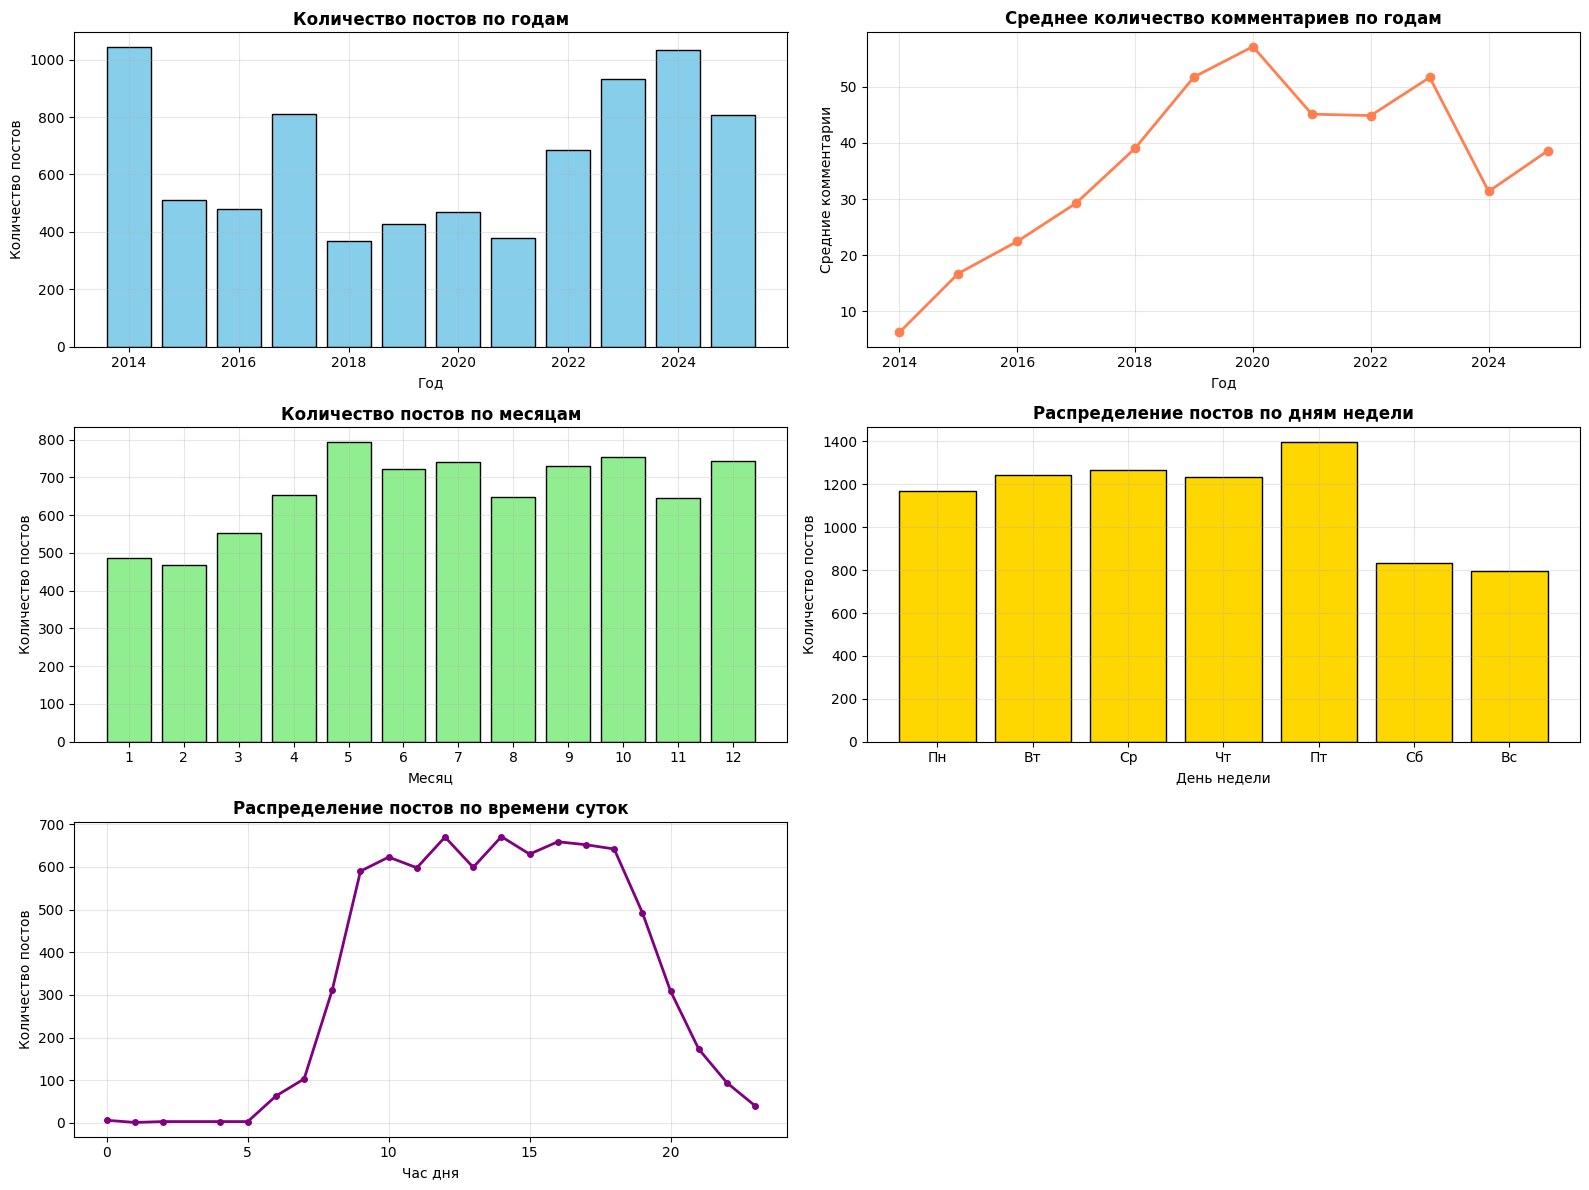

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# 1. Распределение постов по годам
plt.subplot(3, 2, 1)
posts_by_year = df_mosmetro['year'].value_counts().sort_index()
plt.bar(posts_by_year.index, posts_by_year.values, color='skyblue', edgecolor='black')
plt.title('Количество постов по годам', fontweight='bold', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)

# 2. Средние комментарии по годам
plt.subplot(3, 2, 2)
mean_comments_year = df_mosmetro.groupby('year')['comments_count'].mean()
plt.plot(mean_comments_year.index, mean_comments_year.values, 'o-', linewidth=2, markersize=6, color='coral')
plt.title('Среднее количество комментариев по годам', fontweight='bold', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Средние комментарии')
plt.grid(True, alpha=0.3)

# 3. Распределение по месяцам (все годы вместе)
plt.subplot(3, 2, 3)
posts_by_month = df_mosmetro['month'].value_counts().sort_index()
plt.bar(posts_by_month.index, posts_by_month.values, color='lightgreen', edgecolor='black')
plt.title('Количество постов по месяцам', fontweight='bold', fontsize=12)
plt.xlabel('Месяц')
plt.ylabel('Количество постов')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

# 4. Активность по дням недели
plt.subplot(3, 2, 4)
df_mosmetro['day_of_week'] = df_mosmetro['date'].dt.dayofweek
days_count = df_mosmetro['day_of_week'].value_counts().sort_index()
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.bar(day_names, days_count.values, color='gold', edgecolor='black')
plt.title('Распределение постов по дням недели', fontweight='bold', fontsize=12)
plt.xlabel('День недели')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)

# 5. Распределение по часам публикации
plt.subplot(3, 2, 5)
df_mosmetro['hour'] = df_mosmetro['date'].dt.hour
hourly_count = df_mosmetro['hour'].value_counts().sort_index()
plt.plot(hourly_count.index, hourly_count.values, 'o-', linewidth=2, markersize=4, color='purple')
plt.title('Распределение постов по времени суток', fontweight='bold', fontsize=12)
plt.xlabel('Час дня')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [16]:

selected_years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,2025]
df_selected = df_mosmetro[df_mosmetro['year'].isin(selected_years)]

print(f"• Годы: {selected_years}")
print(f"• Постов: {len(df_selected)} ({len(df_selected)/len(df_mosmetro)*100:.1f}% от всех данных)")
print(f"• Комментариев: {df_selected['comments_count'].sum()}")
print(f"• Средние комментарии: {df_selected['comments_count'].mean():.2f}")


• Годы: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
• Постов: 5905 (74.4% от всех данных)
• Комментариев: 246182
• Средние комментарии: 41.69


In [17]:
# Анализ дубликатов
print("\n🔁 ДУБЛИКАТЫ:")
print(f"Полные дубликаты строк: {df_selected.duplicated().sum()}")
print(f"Дубликаты по тексту постов: {df_selected['text'].duplicated().sum()}")
print(f"Дубликаты по ID постов: {df_selected['post_id'].duplicated().sum()}")


🔁 ДУБЛИКАТЫ:
Полные дубликаты строк: 0
Дубликаты по тексту постов: 311
Дубликаты по ID постов: 0


In [18]:
original_size = len(df_selected)
df = df_selected.copy()
 
df_clean = df.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_size - len(df_clean)
print(f"   Удалено дубликатов текста: {duplicates_removed}")

   Удалено дубликатов текста: 311


In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5594 entries, 0 to 5904
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   post_id             5594 non-null   object        
 1   group_name          5594 non-null   object        
 2   group_display_name  5594 non-null   object        
 3   text                5594 non-null   object        
 4   comments_count      5594 non-null   int64         
 5   likes               5594 non-null   int64         
 6   reposts             5594 non-null   int64         
 7   views               5594 non-null   int64         
 8   date                5594 non-null   datetime64[ns]
 9   url                 5594 non-null   object        
 10  text_length         5594 non-null   int64         
 11  year                5594 non-null   int32         
 12  month               5594 non-null   int32         
 13  year_month          5594 non-null   period[M]     
 1

In [20]:
df_clean.describe()

,comments_count,likes,reposts,views,date,text_length,year,month,day_of_week,hour
count,5594.000000,5594.000000,5594.000000,5.594000e+03,5594,5594.000000,5594.000000,5594.000000,5594.000000,5594.000000
mean,42.668037,220.265105,25.702002,1.649915e+04,2022-02-17 05:30:53.671254784,463.492849,2021.623346,6.596711,2.744905,14.373436
min,0.000000,27.000000,0.000000,1.060000e+03,2017-01-01 11:42:07,1.000000,2017.000000,1.000000,0.000000,0.000000
25%,9.000000,104.000000,6.000000,9.625000e+03,2019-08-20 20:18:51.500000,244.250000,2019.000000,4.000000,1.000000,11.000000
50%,22.000000,163.000000,12.000000,1.311850e+04,2022-12-14 02:08:47.500000,419.000000,2022.000000,7.000000,3.000000,14.000000
75%,45.000000,265.000000,25.000000,1.811225e+04,2024-06-28 16:07:45.750000128,617.000000,2024.000000,9.000000,4.000000,17.000000
max,10749.000000,4057.000000,835.000000,1.543454e+06,2025-11-05 09:30:00,4076.000000,2025.000000,12.000000,6.000000,23.000000
std,167.147440,200.803927,49.584932,2.847689e+04,NaN,318.954859,2.732335,3.322527,1.884800,3.553703


In [21]:
df_clean= df_clean[
    (df_clean['views'] > 1) &  # больше 1 просмотра
    (df_clean['text_length'] >=1)  # хотя бы 1 символ
]

In [22]:
df_clean.shape

(5594, 16)

In [23]:
keep_columns = [
    'text',            
    'comments_count'  
]
df_clean= df_clean[keep_columns].copy()
df_clean.head()

,text,comments_count
0,🍂 Осень — лучшее время для горячего чая и люби...,0
1,📲 Мы достигли лучших значений по стабильности ...,8
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0
3,Строить маршруты стало удобнее: мы добавили оп...,20
4,💍 100-я пара заключила брак на станции метро «...,105


In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5594 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            5594 non-null   object
 1   comments_count  5594 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 131.1+ KB


In [25]:
print("🎯 ФИНАЛЬНЫЙ ДАТАСЕТ MOSMETRO:")
print(f"📝 Постов: {len(df_clean)}")
print(f"💬 Комментариев всего: {df_clean['comments_count'].sum()}")
print(f"📈 Средние комментарии: {df_clean['comments_count'].mean():.2f}")
 
print(f"\n📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ:")
print(df_clean['comments_count'].describe())
 
print(f"\n🔍 ДИАПАЗОН КОММЕНТАРИЕВ:")
print(f"• Мин: {df_clean['comments_count'].min()}")
print(f"• Макс: {df_clean['comments_count'].max()}")
print(f"• Медиана: {df_clean['comments_count'].median()}")

🎯 ФИНАЛЬНЫЙ ДАТАСЕТ MOSMETRO:
📝 Постов: 5594
💬 Комментариев всего: 238685
📈 Средние комментарии: 42.67

📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ:
count     5594.000000
mean        42.668037
std        167.147440
min          0.000000
25%          9.000000
50%         22.000000
75%         45.000000
max      10749.000000
Name: comments_count, dtype: float64

🔍 ДИАПАЗОН КОММЕНТАРИЕВ:
• Мин: 0
• Макс: 10749
• Медиана: 22.0


(ограничение) выбросов - заменяем на 95%


In [26]:
# Вычисляем пороговое значение (95-й перцентиль)
percentile_95 = df_clean['comments_count'].quantile(0.95)
 
df_capped = df_clean.copy()

# Заменяем значения выше перцентиля на значение перцентиля
df_capped['comments_count'] = np.where(
    df_capped['comments_count'] > percentile_95,
    percentile_95,
    df_capped['comments_count']
)

print(f"• Максимум ДО: {df_clean['comments_count'].max()}")
print(f"• Максимум ПОСЛЕ: {df_capped['comments_count'].max()}")
print(f"• Значение 95% перцентиля: {percentile_95:.2f}")

• Максимум ДО: 10749
• Максимум ПОСЛЕ: 125.0
• Значение 95% перцентиля: 125.00


In [27]:
df_capped 

,text,comments_count
0,🍂 Осень — лучшее время для горячего чая и люби...,0.0
1,📲 Мы достигли лучших значений по стабильности ...,8.0
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0.0
3,Строить маршруты стало удобнее: мы добавили оп...,20.0
4,💍 100-я пара заключила брак на станции метро «...,105.0
...,...,...
5900,С Новым годом!\n \n/Скульптура «Пионерки с гло...,1.0
5901,Площадки проведения фестиваля «Путешествие в Р...,4.0
5902,График работы Новогоднего поезда #мосметро 1 и...,5.0
5903,"С Новым годом, друзья! :)\n\n/Скульптура «Птич...",12.0


## Task close 

In [28]:
task.close()
print("✅ Задача EDA завершена")

✅ Задача EDA завершена


## New version 2

In [32]:
# # Получаем базовую версию
# base = Dataset.get(
#     dataset_name="VK_Posts_Raw",
#     dataset_project="NLP Course Project"
# )

# print(f"📁 Базовая версия: {base.id}")

# # Создаем новую версию с ТЕМ ЖЕ ИМЕНЕМ  
# updated = Dataset.create(
#     dataset_name="VK_Posts_Raw",   
#     dataset_project="NLP Course Project",
#     parent_datasets=[base.id]   
# )

# print(f"🔄 Создана новая версия: {updated.id}")

# # Сохраняем df_capped
# temp_fixed_path = '../data/processed/df_capped_.csv'
# df_capped.to_csv(temp_fixed_path, index=False)

# # Добавляем файлы в новую версию
# updated.add_files(temp_fixed_path)

# # Устанавливаем метаданные для новой версии
# updated.set_metadata({
#     'description': 'Данные mosmetro с фиксированными выбросами комментариев - только текст и комментарии',
#     'version': '2.0',
#     'parent_dataset_id': base.id,
#     'total_posts': len(df_capped),
#     'columns_remaining': list(df_capped.columns),
#     'processing_changes': [
#         'outlier_removal_95th_percentile',
#         'column_selection_text_and_comments_only'
#     ],
#     'removed_outliers': len(df_selected) - len(df_capped),
#     'removed_percentage': f"{(len(df_selected) - len(df_capped)) / len(df_selected) * 100:.2f}%"
# })

# # Добавляем теги для версии
# updated.add_tags(['v2.0', 'outlier_fixed', 'text_only'])

# # Финализируем
# updated.finalize(auto_upload=True)

# print("✅ Новая версия датасета создана!")
# print(f"📊 Цепочка версий: {base.id} -> {updated.id}")

In [30]:

df_path = '../data/raw/df_mosmetro_sample.csv'
df_capped.to_csv(df_path, index=False, encoding='utf-8')
print("Сохранено") 

Сохранено


df_mosmetro_sample

5594 rows × 2 columns

Максимум: 125.0
Значение 95% перцентиля: 125.00

Регрессия (чистый текст)

## Предобработка текста для NLP

In [8]:
df_exp1 = df= pd.read_csv('../data/raw/df_mosmetro_sample.csv')

In [5]:
df_exp1.shape

(5594, 2)

In [6]:
df_exp1.describe()

,comments_count
count,5594.000000
mean,33.509653
std,33.387779
min,0.000000
25%,9.000000
50%,22.000000
75%,45.000000
max,125.000000


Препроцесс с лемматизацией

*   Приведение к нижнему регистру: Преобразуйте все слова в нижний регистр.
*   Удаление знаков пунктуации и специальных символов.
*   Удаление стоп-слов: Используйте список стоп-слов для русского языка для удаления часто встречающихся, но не несущих важную информацию для анализа слов.
*   Лемматизация: приведите слова к нормальной форме

In [ ]:
import pymorphy3
import re 
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import nltk
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
def preprocess_text(text):
    """
    Предобработка текста: приведение к нижнему регистру, удаление пунктуации,
    стоп-слов и лемматизация
    """
    # Проверка на пустой текст
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Приведение к нижнему регистру
    text = text.lower().strip()
    
    # Удаление знаков пунктуации и специальных символов
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)  # оставляем только русские буквы и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # удаляем лишние пробелы
    
    # Токенизация
    tokens = word_tokenize(text, language='russian')
    
    # Удаление стоп-слов и лемматизация
    stop_words = set(stopwords.words('russian'))
    lemmas = []
    
    for token in tokens:
        if token not in stop_words and len(token) > 2:  # игнорируем короткие слова
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmas.append(lemma)
    
    return " ".join(lemmas)

print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'text' in df_exp1.columns:
    tqdm.pandas()
    df_exp1['processed_text'] = df_exp1['text'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(df_exp1.head())

In [39]:
df_exp1 =  df_exp1.dropna(subset=['processed_text'])
df_exp1 = df_exp1.query('processed_text.str.len() > 20')

df_exp1.shape

(5482, 3)

In [ ]:
df_exp11 = df_exp1[['processed_text','comments_count']] 
exp1_path = '../data/processed/experiments/exp1_regres.csv'
df_exp11.to_csv(exp1_path, index=False, encoding='utf-8')
print(f"💾 Сохранено: {exp1_path}")

💾 Сохранено: ../data/processed/experiments/exp_regres.csv


## Data version 3

In [ ]:
# # Базовая предобработка
# parent_dataset_12 = Dataset.get(dataset_id='477d4366218f481d8f0aacee9dd2e9ba')
# exp1_dataset = Dataset.create(
#     dataset_name="VK_Posts_Raw",
#     dataset_project="NLP Course Project", 
#     parent_datasets=[parent_dataset_12],
# ) 

# temp_exp1_path = '../data/processed/experiments/exp1_regress.csv'
# # ваш код для создания df_exp1
# df_exp11.to_csv(temp_exp1_path, index=False)

# exp1_dataset.add_files(temp_exp1_path)
# exp1_dataset.set_metadata({
#     'description': 'Эксперимент 1: Базовая предобработка текста',
#     'experiment_type': 'basic_preprocessing',
#     'parent_version': '477d4366218f481d8f0aacee9dd2e9ba',
#     'processing_steps': ['lowercase', 'punctuation_removal', 'basic_cleaning']
# })
# exp1_dataset.add_tags(['v3.0', 'preprocess_text', 'text_only'])
# exp1_dataset.finalize(auto_upload=True)
# print(f"✅версия 3 создана: {exp1_dataset.id}")
 

ClearML results page: https://app.clear.ml/projects/622af47656c34ad9b3d661810c7915f5/experiments/968e6deded76478aa11984bc266a4126/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/622af47656c34ad9b3d661810c7915f5/experiments/968e6deded76478aa11984bc266a4126
Displaying metadata in the UI is only supported for pandas Dataframes for now. Skipping!
Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (1 files compressed to 731.05 KiB) to https://files.clear.ml
File compression and upload completed: total size 731.05 KiB, 1 chunk(s) stored (average size 731.05 KiB)
✅версия 3 создана: 968e6deded76478aa11984bc266a4126


In [9]:
import pymorphy3
import re 
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm.auto import tqdm
import nltk

# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Инициализация стеммера для русского языка
stemmer = SnowballStemmer("russian")

def preprocess_text_with_stemming(text):
    """
    Предобработка текста со стеммингом: приведение к нижнему регистру, 
    удаление пунктуации, стоп-слов и стемминг
    """
    # Проверка на пустой текст
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Приведение к нижнему регистру
    text = text.lower().strip()
    
    # Удаление знаков пунктуации и специальных символов
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)  # оставляем только русские буквы и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # удаляем лишние пробелы
    
    # Токенизация
    tokens = word_tokenize(text, language='russian')
    
    # Удаление стоп-слов и стемминг
    stop_words = set(stopwords.words('russian'))
    stems = []
    
    for token in tokens:
        if token not in stop_words and len(token) > 2:  # игнорируем короткие слова
            stem = stemmer.stem(token)
            stems.append(stem)
    
    return " ".join(stems)

print("\nНачало предобработки текста со стеммингом...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'text' in df_exp1.columns:
    tqdm.pandas()
    df_exp1['processed_text_stemmed'] = df_exp1['text'].progress_apply(preprocess_text_with_stemming)
    print("Предобработка текста со стеммингом завершена.")
    display(df_exp1.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.



Начало предобработки текста со стеммингом...


100%|██████████| 5594/5594 [00:05<00:00, 968.09it/s] 

Предобработка текста со стеммингом завершена.


,text,comments_count,processed_text_stemmed
0,🍂 Осень — лучшее время для горячего чая и люби...,0.0,осен лучш врем горяч ча любим произведен проек...
1,📲 Мы достигли лучших значений по стабильности ...,8.0,достигл лучш значен стабильн интернет метр сре...
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0.0,концерт артист проект музык метр прошел москов...
3,Строить маршруты стало удобнее: мы добавили оп...,20.0,стро маршрут стал удобн добав описан пиктограм...
4,💍 100-я пара заключила брак на станции метро «...,105.0,пар заключ брак станц метр маяковск московск м...


In [11]:
df_exp1 =  df_exp1.dropna(subset=['processed_text_stemmed'])
df_exp1 = df_exp1.query('processed_text_stemmed.str.len() > 20')
df_exp11 = df_exp1[['processed_text_stemmed','comments_count']] 
exp3_path = '../data/processed/experiments/exp3_regres.csv'
df_exp11.to_csv(exp3_path, index=False, encoding='utf-8')
print(f"💾 Сохранено: {exp3_path}")

💾 Сохранено: ../data/processed/experiments/exp3_regres.csv


## Data version 4


In [18]:
# # Базовая предобработка
# parent_dataset_12 = Dataset.get(dataset_id='477d4366218f481d8f0aacee9dd2e9ba')
# exp1_dataset = Dataset.create(
#     dataset_name="VK_Posts_Raw",
#     dataset_project="NLP Course Project", 
#     parent_datasets=[parent_dataset_12],
# ) 

# temp_exp1_path = '../data/processed/experiments/exp3_regress.csv'
# # ваш код для создания df_exp1
# df_exp11.to_csv(temp_exp1_path, index=False)

# exp1_dataset.add_files(temp_exp1_path)
# exp1_dataset.set_metadata({
#     'description': 'Эксперимент 3: Базовая предобработка текста',
#     'experiment_type': 'basic_preprocessing_stemming',
#     'parent_version': '477d4366218f481d8f0aacee9dd2e9ba',
#     'processing_steps': ['lowercase', 'punctuation_removal', 'basic_cleaning','stemming']
# })
# exp1_dataset.add_tags(['v3.0', 'preprocess_text', 'text_only','stemming'])
# exp1_dataset.finalize(auto_upload=True)
# print(f"✅версия 4v создана: {exp1_dataset.id}")
 

ClearML results page: https://app.clear.ml/projects/622af47656c34ad9b3d661810c7915f5/experiments/7eb3968b3b0f48dcaa694c62ca04a458/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/622af47656c34ad9b3d661810c7915f5/experiments/7eb3968b3b0f48dcaa694c62ca04a458
Displaying metadata in the UI is only supported for pandas Dataframes for now. Skipping!
Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (1 files compressed to 661.45 KiB) to https://files.clear.ml
File compression and upload completed: total size 661.45 KiB, 1 chunk(s) stored (average size 661.45 KiB)
✅версия 3 создана: 7eb3968b3b0f48dcaa694c62ca04a458


## Task 2


загружаем конфиги

In [ ]:
import sys
import os


# Получаем путь к родительской директории
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Добавляем в PYTHONPATH
sys.path.append(parent_dir)

# Проверяем, что путь добавлен
print("PYTHONPATH:", sys.path)
# Импортируем config
from config_loader import config
 
# путь к конфигу от config объекта
config_path = os.path.join(config.configs_dir, "train_config.yaml")
 
with open(config_path, 'r', encoding='utf-8') as f:
    raw_config = yaml.safe_load(f)
 

PYTHONPATH: ['C:\\Program Files\\Python313\\python313.zip', 'C:\\Program Files\\Python313\\DLLs', 'C:\\Program Files\\Python313\\Lib', 'C:\\Program Files\\Python313', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops\\.env', '', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops\\.env\\Lib\\site-packages', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops\\.env\\Lib\\site-packages\\win32', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops\\.env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops\\.env\\Lib\\site-packages\\Pythonwin', '../config_loader.py', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops', 'c:\\Users\\user\\Documents\\course_project_nlp_mlops']


In [17]:
from clearml import Task, Dataset, OutputModel
# Создаем главную задачу
main_task = Task.init(
    project_name="NLP Course Project",
    task_name="VK Posts - Model Experiments",
    tags=['Ridge','Rf', 'DNN', 'TFidf','parent_task']
)

ClearML Task: created new task id=781a546649314a92b6ea99205b7749a0
======> WARNING! Git diff too large to store (1024kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/b93684681a0643b0b06120e4b9c7d805/experiments/781a546649314a92b6ea99205b7749a0/output/log


In [18]:
main_logger=main_task.get_logger()

Загружаем версионированный датасет

In [19]:
test_size = config.train_config.training.test_size
random_state = config.train_config.training.random_state
os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

Экперимент 1  Ridge Regression (базовый)

In [20]:
exp_config = config.get_experiment_config(1)
dataset_name = exp_config['dataset']

# Получаем информацию о датасете из конфига
dataset_info = raw_config['datasets'][dataset_name]
file_name = dataset_info['file_name']
dataset_id = dataset_info['id']
 
clearml_dataset = Dataset.get(dataset_id=dataset_id) 
dataset_path = clearml_dataset.get_local_copy()
for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file == file_name:  # 
                actual_file_path = os.path.join(root, file)
                print(f"✅ Найден файл: {actual_file_path}")
                break
        if actual_file_path:
            break
df = pd.read_csv(actual_file_path)
 #Определяем X и y  
if 'processed_text' in df.columns and 'comments_count' in df.columns:
    X = df['processed_text']
    y = df['comments_count']
    print("✅ Используем колонки: 'processed_text' и 'comments_count'")
elif 'text' in df.columns and 'comments_count' in df.columns:
    X = df['text']
    y = df['comments_count']
    print("✅ Используем колонки: 'text' и 'comments_count'")
else:
    print("❌ Доступные колонки:", list(df.columns))
    raise ValueError("Не найдены нужные колонки в датасете")
 
test_size = config.train_config.training.test_size
random_state = config.train_config.training.random_state

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, shuffle=True
)

print(f"📈 Разделение данных:")
print(f"   Train: {len(X_train)} samples ({100*(1-test_size):.1f}%)")
print(f"   Test:  {len(X_test)} samples ({100*test_size:.1f}%)")

 #Создаем задачу для эксперимента
task1 = Task.create(
    project_name="NLP Course Project",
    task_name=f"Experiment_1_{exp_config['name']}",
    task_type=Task.TaskTypes.training
)

if 'clearml_dataset' in locals():
 
    task1.set_user_properties(
        dataset_id=str(clearml_dataset.id),
        dataset_name=str(clearml_dataset.name),
        dataset_version=str(clearml_dataset.version),
        dataset_project=str(clearml_dataset.project),
        train_samples=len(X_train),
        test_samples=len(X_test),
        test_size=float(test_size)
    )
    
 
    task1.add_tags([
        f"dataset:{clearml_dataset.name}",
        f"dataset_v:{clearml_dataset.version}",
        f"train_samples:{len(X_train)}",
        f"test_samples:{len(X_test)}"
    ])
    
 
    logger_temp = task1.get_logger()
    logger_temp.report_single_value("train_samples", len(X_train))
    logger_temp.report_single_value("test_samples", len(X_test))
    print(f"🔗 Датасет привязан к задаче {task1.id}")
task1.mark_started()
task1.set_parent(main_task)
logger1 = task1.get_logger()

#Логируем параметры разделения
task1.connect({
    'test_size': test_size,
    'random_state': random_state,
    'train_samples': len(X_train),
    'test_samples': len(X_test)
}, name='data_split_params')
 
tfidf_params = dict(exp_config['tfidf_params'])  
ridge_params = dict(exp_config['ridge_params'])   
tfidf_params['ngram_range'] = tuple(tfidf_params['ngram_range'])

# Логируем параметры
task1.connect(tfidf_params, name='tfidf_params')
task1.connect(ridge_params, name='ridge_params')
 
print(" TF-IDF векторизация ")
vectorizer = TfidfVectorizer(**tfidf_params)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(f"Размерность: {X_train_vec.shape}")

 # Обучение модели
print(" Обучение Ridge Regression...")
model = Ridge(**ridge_params)
model.fit(X_train_vec, y_train)

 
y_pred = model.predict(X_test_vec)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n Метрики:")
print(f"   MAE:  {mae:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   R2:   {r2:.4f}")

# Логируем метрики в ClearML
logger1.report_single_value("MAE", mae)
logger1.report_single_value("RMSE", rmse)
logger1.report_single_value("R2", r2)

# Сохраняем модель в формате pkl
 
os.makedirs("models", exist_ok=True)

# Сохраняем векторайзер
joblib.dump(vectorizer, 'models/ridge_vectorizer.pkl')
print("   ✅ Векторайзер сохранен: models/ridge_vectorizer.pkl")

# Сохраняем модель
joblib.dump(model, 'models/ridge_model.pkl')
print("   ✅ Модель сохранена: models/ridge_model.pkl")

#  Сохраняем артефакты
task1.upload_artifact("ridge_vectorizer.pkl", 'models/ridge_vectorizer.pkl')
task1.upload_artifact("ridge_model.pkl", 'models/ridge_model.pkl')

# Создаем OutputModel для версионирования
output_model = OutputModel(task=task1, framework="scikit-learn", name="ridge_basic")
output_model.update_design(config_dict={
    'model_type': 'Ridge',
    'tfidf_params': tfidf_params,
    'ridge_params': ridge_params
})
output_model.set_metadata(key='MAE', value=float(mae), v_type='float')
output_model.set_metadata(key='R2', value=float(r2), v_type='float')
output_model.set_metadata(key='features', value=int(X_train_vec.shape[1]), v_type='int')
output_model.set_metadata(key='model_format', value='pkl', v_type='str')
output_model.publish()
print(f"✅ Модель сохранена с ID: {output_model.id}")

ridge_metrics = {
    'MAE': mae,
    'R2': r2,
    'model': model,
    'vectorizer': vectorizer,
    'task': task1,
    'output_model': output_model
}

# Завершаем задачу
task1.mark_completed()
print("✅ Эксперимент 1 завершен!")

2025-12-11 15:33:02,436 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
✅ Найден файл: C:/Users/user/.clearml/cache/storage_manager/datasets/ds_968e6deded76478aa11984bc266a4126\exp1_regress.csv
✅ Используем колонки: 'processed_text' и 'comments_count'
📈 Разделение данных:
   Train: 4933 samples (90.0%)
   Test:  549 samples (10.0%)
🔗 Датасет привязан к задаче bda068564e9b4704ad67fcc995c22eae
🔡 TF-IDF векторизация...
   Размерность: (4933, 5000)
🤖 Обучение Ridge Regression...

📊 Метрики:
   MAE:  20.3327
   RMSE: 26.6465
   R2:   0.3911

💾 Сохраняем модель в pkl...
   ✅ Векторайзер сохранен: models/ridge_vectorizer.pkl
   ✅ Модель сохранена: models/ridge_model.pkl
✅ Модель сохранена с ID: 67d0b2f025184b3f81df1b89d10db356
✅ Эксперимент 1 завершен!


Эксперимент 2: Random Forest

In [ ]:
 
exp_config = config.get_experiment_config(2)
dataset_name = exp_config['dataset']
dataset_info = raw_config['datasets'][dataset_name]
file_name = dataset_info['file_name']
clearml_dataset = Dataset.get(dataset_id=dataset_info['id'])
dataset_path = clearml_dataset.get_local_copy()

 
actual_file_path = None
for root, dirs, files in os.walk(dataset_path):
    if file_name in files:
        actual_file_path = os.path.join(root, file_name)
        break
df = pd.read_csv(actual_file_path)

 
X, y = df['processed_text'], df['comments_count']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=config.train_config.training.test_size,
    random_state=config.train_config.training.random_state,
    shuffle=True
)
 # Создание задачи в ClearML
task2 = Task.create(
    project_name="NLP Course Project",
    task_name=f"Experiment_2_{exp_config['name']}",
    task_type=Task.TaskTypes.training
)
 
if 'clearml_dataset' in locals():
    task2.set_user_properties(
        dataset_id=str(clearml_dataset.id),
        dataset_name=str(clearml_dataset.name),
        dataset_version=str(clearml_dataset.version),
        dataset_project=str(clearml_dataset.project),
        train_samples=len(X_train),
        test_samples=len(X_test),
        test_size=float(test_size)
    )
    task2.add_tags([
        f"dataset:{clearml_dataset.name}",
        f"dataset_v:{clearml_dataset.version}",
        f"train_samples:{len(X_train)}",
        f"test_samples:{len(X_test)}"
    ])
    logger_temp = task2.get_logger()
    logger_temp.report_single_value("train_samples", len(X_train))
    logger_temp.report_single_value("test_samples", len(X_test))
    print(f"🔗 Датасет привязан к задаче {task2.id}")

task2.set_parent(main_task)
task2.mark_started()
logger2 = task2.get_logger()
# Логирование параметров
tfidf_params = dict(exp_config['tfidf_params'])
rf_params = dict(exp_config['rf_params'])
svd_params = exp_config['svd']
tfidf_params['ngram_range'] = tuple(tfidf_params['ngram_range'])

task2.connect(tfidf_params, name='tfidf_params')
task2.connect(rf_params, name='rf_params')
task2.connect(svd_params, name='svd_params')

# TF-IDF векторизация
vectorizer = TfidfVectorizer(**tfidf_params)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# SVD
svd = TruncatedSVD(n_components=svd_params['components'], random_state=42)
X_train_vec = svd.fit_transform(X_train_vec)
X_test_vec = svd.transform(X_test_vec)

# Обучение Random Forest
model = RandomForestRegressor(**rf_params)
model.fit(X_train_vec, y_train)

 
y_pred = model.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

logger2.report_single_value("MAE", mae)
logger2.report_single_value("R2", r2)

# Сохранение артефактов
pipeline = {
    'vectorizer': vectorizer,
    'svd': svd,
    'model': model
}
joblib.dump(pipeline, 'models/rf_pipeline.pkl')
task2.upload_artifact("rf_pipeline.pkl", 'models/rf_pipeline.pkl')
rf_metrics = {
    'MAE': mae,
    'R2': r2,
    'model': model,
    'pipeline': pipeline,  # Включает векторайзер, SVD и модель
    'task': task2,
    'output_model': output_model
}
# OutputModel
output_model = OutputModel(task=task2, framework="scikit-learn", name="random_forest")
output_model.update_design(config_dict={
    'model_type': 'RandomForest',
    'n_estimators': rf_params['n_estimators'],
    'max_depth': rf_params['max_depth'],
    'svd_components': svd_params['components']
})
output_model.set_metadata(key='MAE', value=float(mae), v_type='float')
output_model.set_metadata(key='R2', value=float(r2), v_type='float')
output_model.publish()

task2.mark_completed()
print("✅ Эксперимент 2 завершен!")


Эксперимент 3: DNN

In [ ]:

exp_config = config.get_experiment_config(3)
dataset_name = exp_config['dataset']
dataset_info = raw_config['datasets'][dataset_name]
file_name = dataset_info['file_name']
clearml_dataset = Dataset.get(dataset_id=dataset_info['id'])
dataset_path = clearml_dataset.get_local_copy()

 
actual_file_path = None
for root, dirs, files in os.walk(dataset_path):
    if file_name in files:
        actual_file_path = os.path.join(root, file_name)
        break
df = pd.read_csv(actual_file_path)
 
X, y = df['processed_text_stemmed'], df['comments_count']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=config.train_config.training.test_size,
    random_state=config.train_config.training.random_state,
    shuffle=True
)

# Создание задачи  
task3 = Task.create(
    project_name="NLP Course Project",
    task_name=f"Experiment_3_{exp_config['name']}",
    task_type=Task.TaskTypes.training
)
 
if 'clearml_dataset' in locals():
    task3.set_user_properties(
        dataset_id=str(clearml_dataset.id),
        dataset_name=str(clearml_dataset.name),
        dataset_version=str(clearml_dataset.version),
        dataset_project=str(clearml_dataset.project),
        train_samples=len(X_train),
        test_samples=len(X_test),
        test_size=float(test_size)
    )
    task3.add_tags([
        f"dataset:{clearml_dataset.name}",
        f"dataset_v:{clearml_dataset.version}",
        f"train_samples:{len(X_train)}",
        f"test_samples:{len(X_test)}"
    ])
    logger_temp = task3.get_logger()
    logger_temp.report_single_value("train_samples", len(X_train))
    logger_temp.report_single_value("test_samples", len(X_test))
    print(f"🔗 Датасет привязан к задаче {task3.id}")

task3.set_parent(main_task)
task3.mark_started()
logger3 = task3.get_logger()

# Логирование параметров
tfidf_params = dict(exp_config['tfidf_params'])
nn_params = dict(exp_config['nn_params'])
svd_params = exp_config['svd']
tfidf_params['ngram_range'] = tuple(tfidf_params['ngram_range'])

task3.connect(tfidf_params, name='tfidf_params')
task3.connect(nn_params, name='nn_params')
task3.connect(svd_params, name='svd_params')

# TF-IDF + SVD
vectorizer = TfidfVectorizer(**tfidf_params)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

if svd_params['enabled']:
    svd = TruncatedSVD(n_components=svd_params['components'], random_state=42)
    X_train_vec = svd.fit_transform(X_train_vec)
    X_test_vec = svd.transform(X_test_vec)

# Создание модели DNN
model = Sequential()
for i, units in enumerate(nn_params['hidden_units']):
    if i == 0:
        model.add(Dense(units, activation='relu', input_shape=(X_train_vec.shape[1],)))
    else:
        model.add(Dense(units, activation='relu'))
    model.add(Dropout(nn_params['dropout_rate']))
model.add(Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=nn_params['learning_rate']),
    loss='mse',
    metrics=['mae']
)

# Обучение
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_vec, y_train,
    validation_data=(X_test_vec, y_test),
    epochs=nn_params['epochs'],
    batch_size=nn_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

# Метрики
y_pred = model.predict(X_test_vec).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

logger3.report_single_value("MAE", mae)
logger3.report_single_value("R2", r2)

# Сохранение артефактов
preprocessing = {
    'vectorizer': vectorizer,
    'svd': svd,
    'input_dim': X_train_vec.shape[1]
}
joblib.dump(preprocessing, 'models/nn_preprocessing.pkl')
model.save('models/neural_network.h5')
model.save_weights('models/nn_weights.weights.h5')

task3.upload_artifact("nn_preprocessing.pkl", 'models/nn_preprocessing.pkl')
task3.upload_artifact("neural_network.h5", 'models/neural_network.h5')
task3.upload_artifact("nn_weights.weights.h5", 'models/nn_weights.weights.h5')
nn_metrics = {
    'MAE': mae,
    'R2': r2,
    'model': model,
    'preprocessing': preprocessing,  # Включает векторайзер и SVD
    'task': task3,
    'output_model': output_model
}

# OutputModel
output_model = OutputModel(task=task3, framework="tensorflow", name="neural_network")
output_model.update_weights(weights_filename='models/neural_network.h5')
output_model.update_design(config_dict={
    'model_type': 'NeuralNetwork',
    'architecture': str(nn_params['hidden_units']),
    'svd_components': svd_params['components']
})
output_model.set_metadata(key='MAE', value=float(mae), v_type='float')
output_model.set_metadata(key='R2', value=float(r2), v_type='float')
output_model.publish()

task3.mark_completed()
print("✅ Эксперимент 3 завершен!")


2025-12-11 15:59:29,607 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.


█████████████                    42% | 20.36/48.17 MB [00:40<00:59,  2.16s/MB]: 

🔗 Датасет привязан к задаче 2292ea5b03e743caad240c22413496ac


████████████████▉                55% | 26.27/48.17 MB [01:00<01:01,  2.83s/MB]: 

Epoch 1/50


c:\Users\user\Documents\course_project_nlp_mlops\.env\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1290.2086 - mae: 25.8247 - val_loss: 824.3210 - val_mae: 21.0784
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 697.1691 - mae: 19.5066 - val_loss: 758.5647 - val_mae: 19.2014
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 579.3992 - mae: 17.1989 - val_loss: 778.9188 - val_mae: 19.1637
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 493.0115 - mae: 15.9136 - val_loss: 794.1822 - val_mae: 19.2645
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 436.4811 - mae: 14.9286 - val_loss: 795.1412 - val_mae: 19.3117
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 343.0127 - mae: 13.2451 - val_loss: 827.4897 - val_mae: 19.5616
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 261.8191 - mae: 11.5191 - val_loss: 842.5694 - val_mae: 19.5670
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 203.9030 - mae: 10.1467 - val_loss: 838.4842 - val_mae: 19.5321
Epoch 9/50
 71/154

███████████████████▏             62% | 29.73/48.17 MB [01:10<00:52,  2.85s/MB]: 

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 175.4471 - mae: 9.2029 - val_loss: 897.8579 - val_mae: 19.7185
Epoch 10/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 158.0567 - mae: 8.5678 - val_loss: 867.5441 - val_mae: 19.3721
Epoch 11/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148.6700 - mae: 8.1488 - val_loss: 882.4075 - val_mae: 19.7345
Epoch 12/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 135.1040 - mae: 7.7760 - val_loss: 889.7739 - val_mae: 19.8285
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2025-12-11 16:00:42,791 - clearml.model - WARNING - 2 model found when searching for `file://c:\Users\user\Documents\course_project_nlp_mlops\notebooks\models\neural_network.h5`
2025-12-11 16:00:42,792 - clearml.model - WARNING - Selected model `VK Posts - Model Experiments` (id=4150628aa25d420c8ea2d600be77d69b)
2025-12-11 16:00:42,822 - clearml.frameworks - INFO - Found existing registered model id=4150628aa25d420c8ea2d600be77d69b [c:\Users\user\Documents\course_project_nlp_mlops\notebooks\models\neural_network.h5] reusing it.


████████████████████████▍        79% | 37.98/48.17 MB [01:30<00:26,  2.61s/MB]: 

2025-12-11 16:01:07,607 - clearml.storage - INFO - Uploading: 61.43MB from c:/Users/user/Documents/course_project_nlp_mlops/notebooks/models/nn_preprocessing.pkl


███████████████████████████▏     88% | 42.17/48.17 MB [01:40<00:15,  2.55s/MB]: 

2025-12-11 16:01:11,816 - clearml.model - INFO - No output storage destination defined, registering local model models/neural_network.h5


███████████████████████████████ 100% | 48.17/48.17 MB [01:55<00:00,  2.40s/MB]: 


✅ Эксперимент 3 завершен!


In [ ]:
# словарь с результатами всех моделей  
all_models = {
    'Ridge': ridge_metrics,
    'RandomForest': rf_metrics,
    'NeuralNetwork': nn_metrics
}

 
print("\n СВОДКА ВСЕХ МОДЕЛЕЙ:")
for model_name, metrics in all_models.items():
    print(f"   {model_name}: MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")

# лучшая модель по R²  
best_model_name = max(all_models.items(), key=lambda x: x[1]['R2'])[0]
best_metrics = all_models[best_model_name]
print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   R²: {best_metrics['R2']:.4f}")
print(f"   MAE: {best_metrics['MAE']:.4f}")

#  Сохраняем лучшую модель  
 
os.makedirs('artifacts', exist_ok=True)

if best_model_name == 'Ridge':
    best_model_path = os.path.join('artifacts', 'best_model.pkl')
    pipeline = {
        'vectorizer': best_metrics['vectorizer'],
        'model': best_metrics['model'],
        'model_type': 'Ridge'
    }
    joblib.dump(pipeline, best_model_path)
    print(f"   ✅ Лучшая модель сохранена: {best_model_path}")

elif best_model_name == 'RandomForest':
    best_model_path = os.path.join('artifacts', 'best_model_rf.pkl')
    joblib.dump(best_metrics['pipeline'], best_model_path)
    print(f"   ✅ Лучшая модель сохранена: {best_model_path}")

else:  # NeuralNetwork
    best_model_path = os.path.join('artifacts', 'best_model_nn.h5')
    preprocessing_path = os.path.join('artifacts', 'best_model_nn_preprocessing.pkl')
    best_metrics['model'].save(best_model_path)
    joblib.dump(best_metrics['preprocessing'], preprocessing_path)
    print(f"   ✅ Лучшая модель сохранена: {best_model_path}")
    print(f"   ✅ Препроцессинг сохранен: {preprocessing_path}")

# Загружаем лучшую модель в ClearML 
main_task.upload_artifact('best_model', artifact_object=best_model_path)

#  Сохраняем параметры лучшей модели  
best_params = {
    'model_name': best_model_name,
    'R2': float(best_metrics['R2']),
    'MAE': float(best_metrics['MAE']),
    'output_model_id': best_metrics['output_model'].id
}
main_task.connect(best_params, name='best_params')

 
main_logger.report_single_value('Best R2', best_metrics['R2'])
main_logger.report_single_value('Best MAE', best_metrics['MAE'])

 
summary_df = pd.DataFrame([
    {
        'Model': 'Ridge',
        'MAE': ridge_metrics['MAE'],
        'R2': ridge_metrics['R2'],
        'Task ID': ridge_metrics['task'].id,
        'Model ID': ridge_metrics['output_model'].id
    },
    {
        'Model': 'RandomForest',
        'MAE': rf_metrics['MAE'],
        'R2': rf_metrics['R2'],
        'Task ID': rf_metrics['task'].id,
        'Model ID': rf_metrics['output_model'].id
    },
    {
        'Model': 'NeuralNetwork',
        'MAE': nn_metrics['MAE'],
        'R2': nn_metrics['R2'],
        'Task ID': nn_metrics['task'].id,
        'Model ID': nn_metrics['output_model'].id
    }
])
summary_path = 'artifacts/models_summary.csv'
summary_df.to_csv(summary_path, index=False)
main_task.upload_artifact('models_summary', artifact_object=summary_path)
 
print(f"Лучшая модель: {best_model_name}")
print(f"Лучший R²: {best_metrics['R2']:.4f}")
print(f"Лучший MAE: {best_metrics['MAE']:.4f}")
print(f"\nВсе модели сохранены в ClearML:")
print(f"  • Ridge: Task ID {ridge_metrics['task'].id}")
print(f"  • RandomForest: Task ID {rf_metrics['task'].id}")
print(f"  • NeuralNetwork: Task ID {nn_metrics['task'].id}")
  
main_task.mark_completed()
print("\n✅ Все эксперименты завершены!")
print("📊 Проверьте результаты в ClearML Dashboard")



 СВОДКА ВСЕХ МОДЕЛЕЙ:
   Ridge: MAE=20.3327, R²=0.3911
   RandomForest: MAE=20.0222, R²=0.3060
   NeuralNetwork: MAE=19.2014, R²=0.3049

 ЛУЧШАЯ МОДЕЛЬ: Ridge
   R²: 0.3911
   MAE: 20.3327
   ✅ Лучшая модель сохранена: artifacts\best_model_ridge.pkl


Лучшая модель: Ridge
Лучший R²: 0.3911
Лучший MAE: 20.3327

Все модели сохранены в ClearML:
  • Ridge: Task ID bda068564e9b4704ad67fcc995c22eae
  • RandomForest: Task ID 720d24f53d8e48f1bb771bc1fe250005
  • NeuralNetwork: Task ID 2292ea5b03e743caad240c22413496ac

✅ Все эксперименты завершены!
📊 Проверьте результаты в ClearML Dashboard


ClearML Monitor: Reporting detected, reverting back to iteration based reporting
2025-12-11 16:02:56,494 - clearml.Task - WARNING - ### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


: 